In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Callable, Union, Dict, Any

from scripts.logger import Logger
from utils.makepath import makepath as mkp
from config.config_loader import load_config
from data.mri.data_loader import get_data_loader, get_dataset
from scripts.epoch import perform_epoch
from scripts.mri.test.test_utils import get_config_and_model
from encoding_objects.cart_2d_enc_obj import Cart2DEncObj
from utils.metrics import ImageMetricsEvaluator

In [5]:
# device = "cpu"
# device = "cuda"
device = "mps"

In [6]:
root_dir = mkp("..", "..")

In [7]:
# data_config, u_tv_net, u_tgv_net = get_data_config_and_models(
#     device=device,
#     root_dir=root_dir,
# )

In [8]:
u_tv_config, u_tv_net = get_config_and_model(
    model_id="u_tv_fixed",
    state_dict_file="model_state_dict_43.pth",
    device=device,
    root_dir=root_dir,
)
print(f"U-TV sigma: {u_tv_net.sigma}")
print(f"U-TV tau: {u_tv_net.tau}")

Config loaded from file ../../pretrained/u_tv_fixed/config.yaml
Config loaded from dict
Loading model on device: mps
Loading model on device: mps
Norm of operator A: 1
Norm of gradient operator nabla: 2.8284270763397217
L: 3.0
PDHG net device: mps
Using my U-Net implementation!
Using my own UNet2d class
Loaded model state dict from ../../pretrained/u_tv_fixed/model_state_dict_43.pth
u_tv_fixed model loaded
U-TV sigma: 0.12612056732177734
U-TV tau: 0.8809912204742432


In [9]:
u_tgv_config, u_tgv_net = get_config_and_model(
    model_id="u_tgv_fixed",
    state_dict_file="model_state_dict_72.pth",
    device=device,
    root_dir=root_dir,
)
print(f"U-TGV sigma: {u_tgv_net.sigma}")
print(f"U-TGV tau: {u_tgv_net.tau}")

Config loaded from file ../../pretrained/u_tgv_fixed/config.yaml
Config loaded from dict
Loading model on device: mps
Loading model on device: mps
Norm of operator A: 1
Norm of gradient operator nabla: 2.8284270763397217
L: 3.0
PDHG net device: mps
Using my U-Net implementation!
Using my own UNet2d class
Loaded model state dict from ../../pretrained/u_tgv_fixed/model_state_dict_72.pth
u_tgv_fixed model loaded
U-TGV sigma: 0.10886668413877487
U-TGV tau: 1.0206162929534912


In [10]:
u_tv_config["data"]

{'dataset': 'mri',
 'data_path': PosixPath('../../tmp/mri_data'),
 'train_file_name': 'x_true_train_3000.pt',
 'val_file_name': 'x_true_val_150.pt',
 'test_file_name': 'x_true_test_302.pt',
 'data_scale_factor': 1000,
 'loading_method': 'dynamically_noised',
 'train_num_samples': 3000,
 'val_num_samples': 150,
 'test_num_samples': 302,
 'img_size': 320,
 'min_standard_deviation_sigma': 0.0,
 'max_standard_deviation_sigma': 0.2,
 'min_acceleration_factor_R': 4,
 'max_acceleration_factor_R': 8,
 'R_data_type': 'int',
 'batch_size': 1,
 'random_seed': 42}

In [11]:
u_tgv_config["data"]

{'dataset': 'mri',
 'data_path': PosixPath('../../tmp/mri_data'),
 'train_file_name': 'x_true_train_3000.pt',
 'val_file_name': 'x_true_val_150.pt',
 'test_file_name': 'x_true_test_302.pt',
 'data_scale_factor': 1000,
 'loading_method': 'dynamically_noised',
 'train_num_samples': 3000,
 'val_num_samples': 150,
 'test_num_samples': 302,
 'img_size': 320,
 'min_standard_deviation_sigma': 0.0,
 'max_standard_deviation_sigma': 0.2,
 'min_acceleration_factor_R': 4,
 'max_acceleration_factor_R': 8,
 'R_data_type': 'int',
 'batch_size': 1,
 'random_seed': 42}

In [12]:
assert u_tv_config["data"] == u_tgv_config["data"]
data_config = u_tv_config["data"]
data_config = u_tgv_config["data"]

In [13]:
acceleration_factor_R = 8
gaussian_noise_standard_deviation_sigma = 0.05

In [14]:
test_dataset = get_dataset(
    data_config=data_config,
    dataset_type="preprocessed",
    action="test",
    device=device,
    acceleration_factor_R=acceleration_factor_R,
    gaussian_noise_standard_deviation_sigma=gaussian_noise_standard_deviation_sigma
)



Ground truth data shape: torch.Size([302, 320, 320])
min abs val of ground truth: 1.8633207901075366e-06
max abs val of ground truth: 1.385725498199463

Ground truth data shape: torch.Size([302, 320, 320])
Memory size of ground truth: 235.9375 MB
Corrupted data shape: torch.Size([302, 320, 320])
Memory size of corrupted data: 235.9375 MB
min abs val of corrupted: 2.1736816506745527e-06
max abs val of corrupted: 1.1920750141143799

Corrupted kdata shape: torch.Size([302, 1, 320, 320])
Memory size of corrupted kdata: 235.9375 MB

kmasks shape: torch.Size([302, 320, 320])
Memory size of kmasks: 235.9375 MB



In [15]:
enc_obj = Cart2DEncObj()

In [16]:
metrics_evaluator = ImageMetricsEvaluator(
    complex_to_real_conversion="abs", device=device)

NOTE: Complex-to-real conversion method: abs


In [17]:
out_dir = mkp(".", str(device))
os.makedirs(out_dir, exist_ok=True)
print(f"Output directory: {out_dir}")

Output directory: mps


In [19]:
plt.figure(figsize=(24, 20))
from scripts.mri.test.test_utils import TestImageSaver
test_image_saver = TestImageSaver(
    acc_factor_R=acceleration_factor_R,
    gaussian_noise_sigma=gaussian_noise_standard_deviation_sigma,
    complex_to_real_conversion="abs",
    root_dir=root_dir,

    # saves=False,
    # sample_idx=0,
    # dataset=test_dataset,
    data_config=data_config,
    # enc_obj=enc_obj,
    u_tv_net=u_tv_net,
    u_tgv_net=u_tgv_net,
    num_iters=256,

    out_dir=out_dir,
    # metrics_evaluator=metrics_evaluator,
    x_clip_range=(0, 0.5),
    kdata_clip_range=(0, 0.2),
    lambda1_v_clip_range=(0, 0.05),
    lambda0_w_clip_range=(0, 1),
    lambda_ratio_clip_range=(0, 10),
    tqdm_progress_bar=tqdm,

    fraction_of_line_width=1,
    height_to_width_ratio=1,
    device=device,
)




Ground truth data shape: torch.Size([302, 320, 320])
min abs val of ground truth: 1.8633207901075366e-06
max abs val of ground truth: 1.385725498199463

Ground truth data shape: torch.Size([302, 320, 320])
Memory size of ground truth: 235.9375 MB
Corrupted data shape: torch.Size([302, 320, 320])
Memory size of corrupted data: 235.9375 MB
min abs val of corrupted: 2.1736816506745527e-06
max abs val of corrupted: 1.1920750141143799

Corrupted kdata shape: torch.Size([302, 1, 320, 320])
Memory size of corrupted kdata: 235.9375 MB

kmasks shape: torch.Size([302, 320, 320])
Memory size of kmasks: 235.9375 MB

NOTE: Complex-to-real conversion method: abs


<Figure size 2400x2000 with 0 Axes>

batch_x_corrupted.shape = torch.Size([1, 320, 320])
batch_x_true.shape = torch.Size([1, 320, 320])
batch_kdata_corrupted.shape = torch.Size([1, 1, 320, 320])
batch_undersampling_kmask.shape = torch.Size([1, 320, 320])
Reconstructing with U-TGV ...


  0%|          | 0/256 [00:00<?, ?it/s]

Reconstructing with U-TV ...


  0%|          | 0/256 [00:00<?, ?it/s]

Saving kdata image
Saving ground_truth image
Saving mask image
Saving kdata_corrupted image
Saving zero_filled image
abs - zero_filled metrics: PSNR = 24.00, SSIM = 0.6221
Saving lambda image
Saving u_tv image
abs - u_tv metrics: PSNR = 29.58, SSIM = 0.7724
Saving lambda0_w image
Saving lambda1_v image
Saving u_tgv image
abs - u_tgv metrics: PSNR = 29.93, SSIM = 0.8355
Saving lambda0_w_over_lambda1_v image


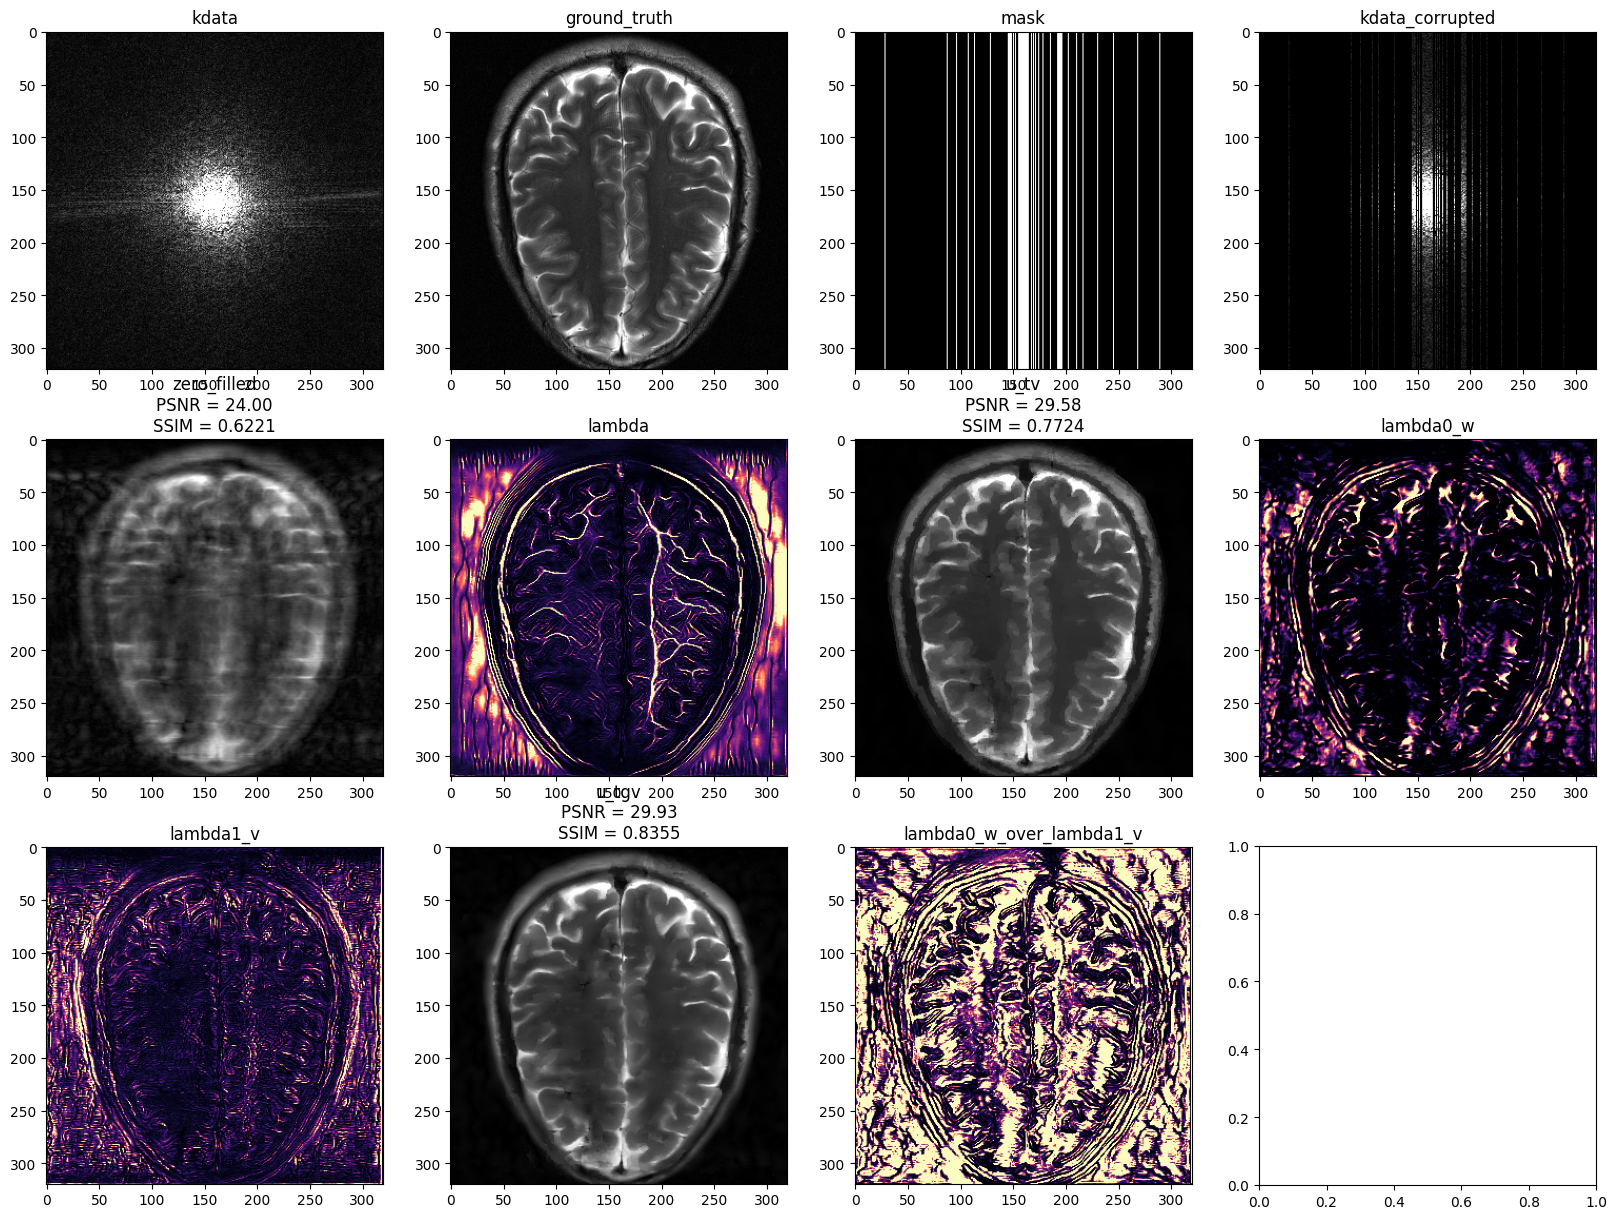

In [20]:
test_image_saver.test_sample_and_save_images(
    sample_idx=0,
)

In [ ]:
def get_zero_filled(
    kdata,
    kmask,
    x,
    csmap
):
    return x, None

In [ ]:
def test_and_save_results(
        config: Dict[str, Any],
        reconstructor: Union[torch.nn.Module, Callable],
        general_action: str,
        acceleration_factor_R: int,
        sigma: float,
        force_overwrite: bool = False
):
    print(f"Testing with {general_action} data, R = {acceleration_factor_R}, sigma = {sigma}")

    test_data_loader = get_data_loader(
        config=config,
        action=general_action,
        dataset_type="preprocessed",
        device=device,
        acceleration_factor_R=acceleration_factor_R,
        gaussian_noise_standard_deviation_sigma=sigma
    )

    specific_action = f"{general_action}-R_{acceleration_factor_R}-sigma_{sigma:.2f}".replace(".", "_")

    test_logger = Logger(
        action=specific_action,
        config=config,
        force_overwrite=force_overwrite
    )
    test_logger.init_metrics_logging_options()
    # Set the intermediate log frequency to 1
    test_logger.log_freq_by_iter["intermediate"] = 1

    avg_metrics = perform_epoch(
        data_loader=test_data_loader,
        pdhg_net=reconstructor,
        is_training=False,
        logger=test_logger,
        # learning_rate_scheduler=None,
        # optimizer=None,
        tqdm_progress_bar=tqdm
    )
    return avg_metrics

In [ ]:
zero_filled_config = load_config(
    config_choice=mkp(root_dir, "config", "zero_filled_config.yaml"),
    is_training=False,
    root_dir=root_dir
)

Config loaded from file ../../config/zero_filled_config.yaml


In [ ]:
# acceleration_factor_R = 4
# sigma = 0.15
# general_action = "test"
# # action = "val"
# force_overwrite = False
# # force_overwrite = True

for acceleration_factor_R in []:
    for sigma in []:
        test_and_save_results(
            config=zero_filled_config,
            reconstructor=get_zero_filled,
            general_action="test",
            acceleration_factor_R=acceleration_factor_R,
            sigma=sigma,
            force_overwrite=False
            # force_overwrite=True
        )